In [1]:
# setup the environment
from detection import WatermarkInClassroom, WatermarkInClassroomLOCNESS, WatermarkInClassroomWeighted
from detection_utils import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

temp = 0.7
ngram = 4
model = "phi"
method = "openai"

prompt = 'P1'
df = load_dataset(data='ETS', model_list=[model], method_list=[method], ngram=ngram)

df = df[df['Prompt'] == prompt]

base = 1
alternatives = [2, 3, 4, 5, 6, 7]
adjust_alpha = 0.05
random_seed = 0

# The Problem

The professor is teaching a class in which she collects essays from students. She has agreed to allow moderate use of AI to check for grammatical errors in the essays. However, she is concerned that students may use AI to write their essays for them. 

Watermarked AI content allows the professor to check if the essay includes AI-generated content, given a specified $\alpha$ value. However, existing watermarking methods only offer a binary decision: either the essay contains AI-generated content or it does not. The professor wants to know how much of the essay is AI-generated, so she can determine if the student has used AI to write their essay in an appropriate manner.

First, we use the ETS corpus to investigate the information hidden behind the watermark signal.

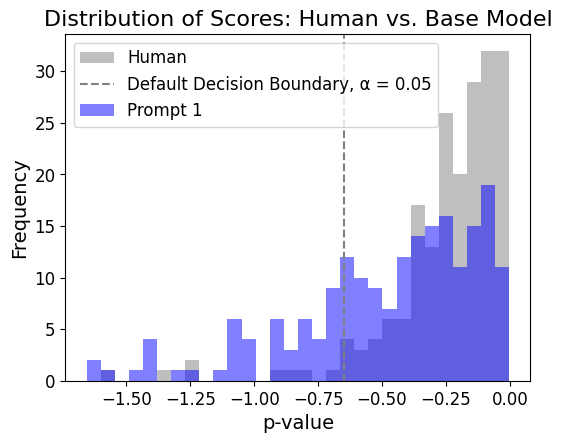

Human, 4.00 % samples below α = 0.05
Prompt 1, 25.50 % samples below α = 0.05


In [2]:
experiment = WatermarkInClassroom(df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, random_state=random_seed)
experiment.visualize_base_against_human()

# Visual Inspection of $p$-Values

The professor teaches a big class with 100 students. 
She has asked the students to write an essay on a specific topic. The students are allowed to use AI to check for grammatical errors, but they are not allowed to use AI to write their essays for them.


Method: Visual inspection of the provided p-values.

When the professor receives the essays, she makes a histogram of the p-values of the watermark signal. She then visually inspects the histogram and decides whether some p-values are too high. If some essays have p-values that are too high, she decides that the essay might be a result of AI usage that's not allowed.

Pro: easy to implement, no need for any additional data.

Con: the professor has to visually inspect the p-values and decide if they are too high. This is subjective and may lead to inconsistent decisions. As shown in the example below, when the professor inspects the histogram (in gray), it is reasonable to believe that the left tail of the histogram is not a result of permitted AI usage. However, if the professor would like to control the false positive rate to $alpha=0.05$, it is not clear how she could set the threshold.

Nonetheless, visual inspection remains a reasonable method when no prior information is available.


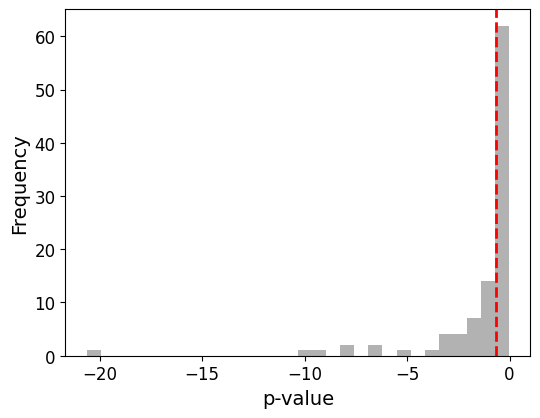

In [3]:
def visualize_outlier_wrapper(experiment, metric='pval', **kwargs):
    frac = 0.5
    n_total = 100
    n_samples = int(n_total*frac)
    df_inlier = experiment.df_heldout.sample(n=n_total-n_samples, random_state=42)
    df_outlier = experiment.df_outlier.sample(n=n_samples, random_state=42)
    experiment.visualize_outlier(df_inlier, df_outlier, metric=metric, **kwargs)
    

visualize_outlier_wrapper(experiment, mode="hide")

We reveal which essays follow the AI-usage guidelines below. 

We see that there can be overlaps between the two distributions:

- when the student is not following the AI-usage guidelines, the watermark signal can be quite strong. However, this is not always the case. 

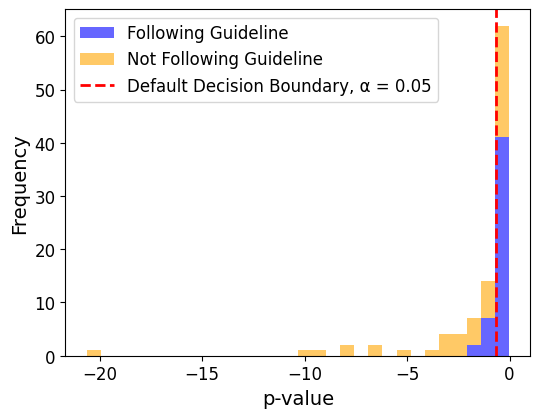

In [4]:
visualize_outlier_wrapper(experiment)

It is totally possible that a student has produced a well-written essay by themselves first, but did not follow the AI usage guidelines set by the professor to polish the essay. In this case, the resulting essay may contain relatively little AI-generated content.
 
Below are a few examples of essays with different prompts to improve the quality of the essay. Nonetheless, the AI-edit resulted in little change to the essay. 

In practice, this might be okay as far as the professor is concerned: a well-written essay is a well-written essay, if the involvement of AI is moderate, the professor may be okay with it.

High Similarity Score: bleu
0.9795189854912092, Prompt type: 5
Original Essay:
It is a common thought that it is better to have broad knowledge of many academic subjects than to specialize in one specific subject. This is no surprise when we think about how good it can make someone look in a cocktail party or in a fancy dinner. Indeed, who does not admire people who know about varied subjects? But can we say that having specialized knowledge is not as worthy as knowing a little bit about a lot of things?

I think that society does need specialists, that is people with highly specialized skills and knowledge. Indeed, some professions require high accuracy in knowledge. For example, a surgeon is generally specialized in a part of the body, as brain surgeons are. In my opinion, that is due to the fact that people concentrating on a subject learn a lot more about it than people learning a little bit about everything and who just cannot find the time to go further in each field. Other profe

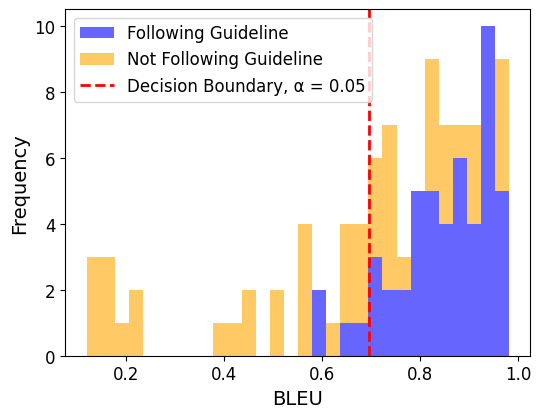

In [5]:
visualize_outlier_wrapper(experiment, metric='bleu', alpha=adjust_alpha)

Hence, we adjust our definition of "not following the AI-usage guidelines" below:
- when the student is not following the AI-usage guidelines and the result led to a significant change in the essay, as measured by the "BLEU" score, we can say that the student is not following the AI-usage guidelines.
- when the student is not following the AI-usage guidelines but the result led to a small change in the essay, we can say that the student is a "suspect" of not following the AI-usage guidelines.

In all our experiments, we make the assumption that the professor is not interested in catching the "suspects" of not following the AI-usage guidelines.

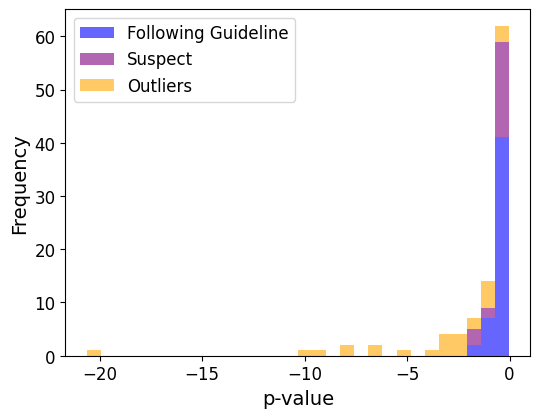

In [6]:
visualize_outlier_wrapper(experiment, metric='pval', mode="suspect")

# Scenario 1: 

As mentioned before, if the professor would like to control the false positive rate to $\alpha=0.05$, some prior information is needed. In this case, we assume the following:
    
- in addition to the essays from the current assignment of interest, the professor has a collection of essays from students for the same writing prompt in the past years. She wants to use these essays to make a decision about whether there is excessive AI usage in the current year's essays. 

In this scenario, we can apply conformal methods to conduct outlier detection with theoretical guarantees. Let $s_1, s_2, \ldots, s_n$ be the p-values of the watermark signal for the essays in the current assignment provided by the watermarking detection API/algorithm. We use this as our "score" for the essays. 

We can then use the essays from the past years to build a "calibration set" of essays in the following way:
1/ We use a language model to edit the essays in the past years using the prompt provided by the professor and obtain a set of watermarked essays. Suppose there were $n$ essays in the past years and let $X_1, X_2, \ldots, X_n$ be these essays. We call this set of essays the "calibration set" and write $\mathcal{D}^{cal} = \{1, ..., n\}$.
2/ We then use the watermarking detection API/algorithm to obtain the p-values of the watermark signal for the essays in the past years. Let $s(X_1), s(X_2), \ldots, s(X_n)$ be the p-values of the watermark signal of these essays. In the conformal prediction language, we call the watermarking detection API/algorithm the "scoring function" $s(\cdot)$.
3/ After the students submitted their essays $X_{n+1}, ..., X_{n+m}$ for this assignment, we again use the watermarking detection API/algorithm to obtain the p-values of the watermark signal for the essays in the current assignment. 

For each essay $x$ in the current assignment, we estimate the conformal p-value as follows:
$$
\hat u(X) = \frac{1 + \sum_{i\in \mathcal{D}^{cal}} {\bf 1}(s(X_i) \leq s(X))}{n + 1}
$$
where ${\bf 1}(\cdot)$ is the indicator function. This gives us marginally superuniform (conservative) p-values satisfying the following property:
$$
\mathbb{P}(\hat u(X) \leq \alpha) \leq \alpha
$$
for any $\alpha \in (0, 1)$ and any $X$ that follows the same distribution as the essays in the calibration set (i.e. the essays were first written in the same way as the essays from the past years and then edited by the AI following the proposed guideline.)


Running conformal tests with 50 in-domain training samples, random_seed=0
Training set size: 50
Number of inliers: 1024
Number of outliers: 565
Marginal Conformal p-values
False positive rate: 4.69%
Power: 79.65%


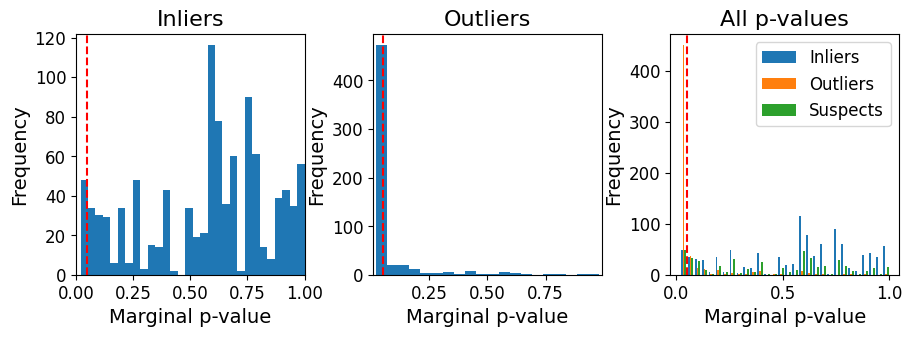

In [7]:
def run_conformal_tests_wrapper(experiment, n_trains, random_seed = random_seed, verbose = True, train_groups = False, **kwargs):
    results = []
    for n_train in n_trains:
        verbose_ = verbose
        result = {}
        result['n_train'] = n_train
        if verbose_:
            print(f"Running conformal tests with {n_train} in-domain training samples, random_seed={random_seed}")
        df_train = experiment.df_heldout.sample(n=n_train, random_state=random_seed)
        if verbose_:
            print(f"Training set size: {len(df_train)}")
        if train_groups:
            result |= experiment.run_conformal_tests(df_train, train_groups = df_train['essay_id'], verbose=verbose_, **kwargs)
        else:
            result |= experiment.run_conformal_tests(df_train, verbose=verbose_, **kwargs)
        verbose_ = False
        results.append(result)
    return results

# call it
result = run_conformal_tests_wrapper(experiment, n_trains = [50], alpha=0.05, save_path = f"figs/{model}_{method}_{base}_scenario_1.png")

# Scenario 3:
The professor has a collection of essays from students for different writing prompts in the past years. She wants to use these essays to make a decision about whether there is excessive AI usage in the current year's essays.

This presents a natural hierarchical structure in the data. The essays from the past years can be grouped into $K$ different groups, where each group corresponds to a different writing prompt.

Here we apply the hierarchical conformal prediction method introduced in [Distribution-free inference with hierarchical data](https://arxiv.org/pdf/2306.06342).

The conformal p-values are computed in the following way:
$$\frac{1}{(K+1)}[1 + \frac{\sum_{k=1}^K\sum_{i=1}^{n_k} {\bf 1}\{s(X_i) \le s(x)\}}{n_k}]$$
where $n_k$ is the number of essays in group $k$ and $s(X_i)$ is the p-value of the watermark signal for essay $X_i$ in group $k$.

count                    200
unique                   165
top       <ICLE-US-SCU-0004>
freq                       3
Name: essay_id, dtype: object
Running conformal tests with 200 in-domain training samples, random_seed=42
Training set size: 200
Number of inliers: 185
Number of outliers: 103
Marginal Conformal p-values
False positive rate: 4.32%
Power: 76.70%


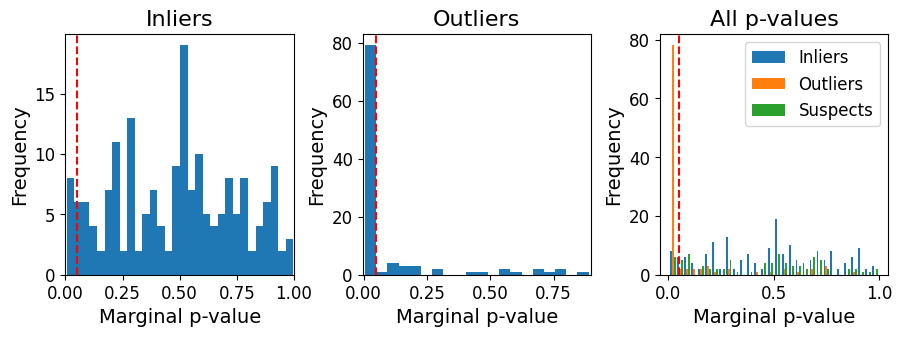

In [8]:
LOCNESS_df = load_dataset(data='LOCNESS', model_list=[model], method_list=[method], ngram=ngram)

experiment_LOCNESS = WatermarkInClassroomLOCNESS(LOCNESS_df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, random_state = random_seed)

print(experiment_LOCNESS.df_heldout['essay_id'].describe())

result = run_conformal_tests_wrapper(experiment_LOCNESS, random_seed = 42, n_trains = [200], alpha=0.05, train_groups = True, save_path = f"figs/{model}_{method}_{base}_scenario_2.png")

# Extensions

## Distribution Shift and Transfer Learning

English is not the first language for many students in the class. The professor is wondering if non-native English speakers in her class may incur more help from AI to write their essays. 

We illustrate this by comparing the ETS corpus with the LOCNESS dataset. 



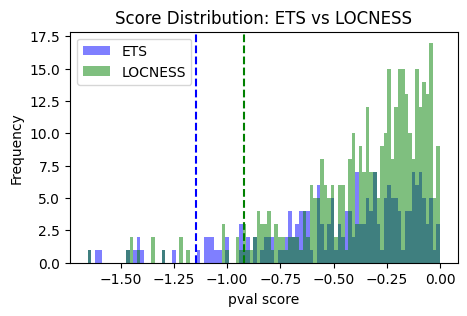

In [9]:
experiment_weighted = WatermarkInClassroomWeighted(df, model, method, base, alternatives, metric='pval', adjust_alpha=adjust_alpha, df_majority=LOCNESS_df, random_state = random_seed)

experiment_weighted.compare_score_distribution(metric = 'pval')

We observe that when the essays are edited by AI only for grammatical errors, the essays written by non-native English speakers are likely to include more watermark signals than the essays written by native English speakers. This is because the AI-editing process is more likely to change the content of the essay for non-native English speakers than for native English speakers, as shown in the comparison of the BLEU scores between the original and edited essays below.

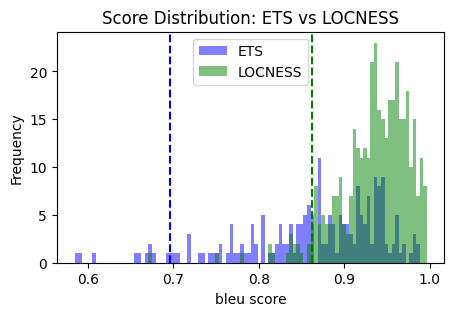

In [10]:
experiment_weighted.compare_score_distribution(metric = 'bleu')

She wants to be able to detect excessive AI usage in the essays, but she also wants to be fair and not penalize students who are not native English speakers.

In the U.S. context, international students are likely a minority in the class. Hence, the professor may only have a few essays from non-native English speakers in the calibration set, which alone may not be enough to build a reliable calibration set for non-native English speakers in the class.

Hence, we apply a weighted variant of the conformal framework so we can use the essays from the native English speakers in the calibration set to help build a reliable calibration set for non-native English speakers. It works as follows:

1. Let $p(x)$ denote the probability density function of the scores of the essays written by both native and non-native English speakers. Let $q(x)$ denote the probability density function of the scores of the essays by non-native English speakers.
2. If we can compute the likelihood ratio $\frac{q(x)}{p(x)}$, then we can assign importance weights to each essay in the calibration set based on how representative they are of the distribution $q$, and we can use these weights to build a weighted calibration set. Specifically, for a new essay $X_{n+1}$ written by a non-native English speaker from the class, we can compute

$$
w_i = \frac{\frac{q(s(X_i))}{p(s(X_i))}}{\sum_{j=1}^n \frac{q(s(X_j))}{p(s(X_j))} + \frac{q(s(X_{n+1}))}{p(s(X_{n+1}))}} \quad \text{for } i = 1, \dots, n,\;\text{ and } w_{n+1} = \frac{\frac{q(s(X_{n+1}))}{p(s(X_{n+1}))}}{\sum_{j=1}^n \frac{q(s(X_j))}{p(s(X_j))} + \frac{q(s(X_{n+1}))}{p(s(X_{n+1}))}}
$$

Then, we compute the $\alpha$-quantile of the weighted empirical distribution of conformity scores $s(X_1), \dots, s(X_n)$ using the weights $w_1, \dots, w_n$. Specifically, we reject the null hypothesis (that the essay was written without excessive AI use) if
$$
\sum_{i=1}^n w_i \cdot \mathbb{1}\{ s(X_i) \leq s(X_{n+1}) \}+w_{n+1}< \alpha
$$

The difficulty is that we do not know the likelihood ratio $\frac{q(x)}{p(x)}$ in practice. Hence, we need to estimate it from the data. One particular choice is the kernel density estimator, which is a non-parametric method to estimate the probability density function of a random variable. We apply Gaussian kernel density estimation to estimate $p(x)$ and $q(x)$ separately and then compute the likelihood ratio $\frac{q(x)}{p(x)}$. Notice that this is well-defined because $q(x)$ is supported on a subset of the support of $p(x)$.

Running conformal tests with 5 in-domain training samples, random_seed=0
Training set size: 5


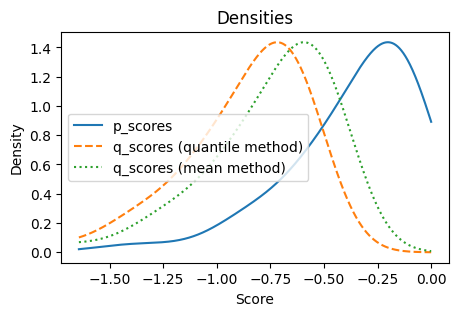

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 0.00
In Distribution Only Power: 0.00
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 4.39
Combined Weighted (quantile) Power: 78.94
Combined Weighted (mean) False positive rate: 5.08
Combined Weighted (mean) Power: 81.24
Running conformal tests with 15 in-domain training samples, random_seed=0
Training set size: 15


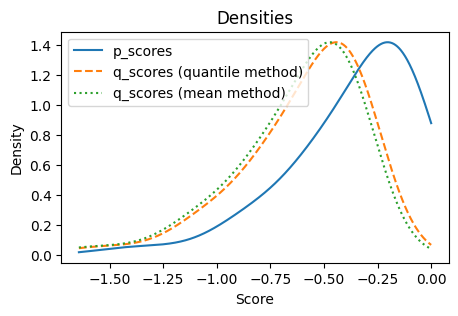

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 0.00
In Distribution Only Power: 0.00
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 7.23
Combined Weighted (quantile) Power: 84.42
Combined Weighted (mean) False positive rate: 7.03
Combined Weighted (mean) Power: 84.42
Running conformal tests with 30 in-domain training samples, random_seed=0
Training set size: 30


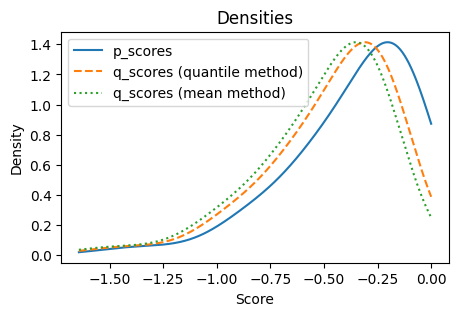

Number of outliers: 565
Marginal Conformal p-values
In Distribution Only False positive rate: 8.01
In Distribution Only Power: 86.02
Combined Unweighted False positive rate: 13.48
Combined Unweighted Power: 89.73
Combined Weighted (quantile) False positive rate: 10.74
Combined Weighted (quantile) Power: 87.79
Combined Weighted (mean) False positive rate: 8.89
Combined Weighted (mean) Power: 87.08


In [11]:
results = run_conformal_tests_wrapper(experiment_weighted, n_trains = [5, 15, 30], alpha=0.05, verbose=True)